In [1]:
SAVE_DIR = "./static/assets/svg/figure"

In [2]:
# Parameters
SAVE_DIR = (
    "/Users/austenmoney/Documents/hubmap/portal-ui/context/app/static/assets/svg/figure"
)


In [3]:
from pathlib import Path

# folder of the current notebook
NOTEBOOK_DIR = Path().resolve()

outdir = NOTEBOOK_DIR / "context" / "app" / "static" / "assets" / "svg" / "figure"
outdir.mkdir(parents=True, exist_ok=True)

# Overview of HuBMAP Portal Data

# Setup

In [4]:
# Import the required packages
%pip install numpy pandas requests matplotlib

import requests
import json
import math
import textwrap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

from IPython.display import display, HTML, SVG
from html import escape
search_api = "https://search.api.hubmapconsortium.org/v3/portal/search"

Note: you may need to restart the kernel to use updated packages.


# Figure 1a

In [5]:
hits = json.loads(
    requests.post(
        search_api,
        json={
    "size": 0,
    "query": {
        "bool": {
            # Exclude invalid/new datasets from count
            # using `must_not` for this allows entities without a mapped status to still be matched
            "must_not": {
                "terms": {
                    "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                }
            },
            # Nested musts are necessary to form an AND of ORs (i.e. a MUST of SHOULDs)
            "must": {
                "bool": {
                    "must": [
                        {
                            # Exclude donors/samples with no associated datasets
                            "bool": {
                                "should": [
                                    # Either not a donor/sample
                                    {
                                        "bool": {
                                            "must_not": {
                                                "terms": {
                                                    "entity_type.keyword": ["Donor", "Sample"]
                                                }
                                            }
                                        }
                                    },
                                    # or has at least one descended dataset
                                    {
                                        "bool": {
                                            "must": {
                                                "exists": {
                                                    "field": "descendant_counts.entity_type.Dataset"
                                                }
                                            }
                                        }
                                    }
                                ]
                            }
                        },
                        {
                            # Only include collections with a DOI in count
                            "bool": {
                                "should": [
                                    {
                                        "bool": {
                                            "must_not": {
                                                "term": {
                                                    "entity_type.keyword": "Collection"
                                                }
                                            }
                                        }
                                    },
                                    {
                                        "bool": {
                                            "must": [
                                                {"exists": {"field": "doi_url"}},
                                                {"exists": {"field": "registered_doi"}}
                                            ]
                                        }
                                    }
                                ]
                            }
                        },
                    ]
                }
            }
        }
    },
    "aggs": {
        "entity_type": {
            "terms": {"field": "entity_type.keyword"}
        }
    }
}).text
)['aggregations']['entity_type']['buckets']

organHits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a sample
                                    "term": {
                                        "entity_type.keyword": "Sample"
                                    }
                                },
                                {
                                    # Ensure the sample has a mapped organ
                                    "exists": {
                                        "field": "mapped_organ"
                                    }
                                },
                                {
                                    # Ensure the sample has at least one associated dataset
                                    "exists": {
                                        "field": "descendant_counts.entity_type.Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "organs": {
                    "terms": {
                        "field": "mapped_organ.keyword",
                        "size": 100
                    }
                }
            }
        }
    ).text
)['aggregations']['organs']['buckets']

vizHits = int(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}},
                        {"term": {"visualization": "true"}},
                    ]
                }
            }
        }
    ).json()["hits"]["total"]["value"]
)

# Count distinct raw dataset types (assays) across all valid Datasets
assayHits = len(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}}
                    ],
                }
            },
            "aggs": {
                "assay_types": {
                    "terms": {
                        "field": "raw_dataset_type.keyword",
                        "size": 500  # bump if you expect >500 unique assays
                    }
                }
            }
        }
    ).json()["aggregations"]["assay_types"]["buckets"]
)


def render_entity_summary(hits, organHits=None, vizHits=None, assayHits=None):
    # Normalize & pluralize names
    cards = sorted(
            [
                (d.get("key", ""), int(d.get("doc_count", 0)))
                for d in hits
                if d.get("key", "").lower() != "support"
            ],
            key=lambda x: x[0]
        )
    if organHits is not None:
        cards.append(("Organ", len(organHits)))

    if vizHits is not None:
        cards.append(("Visualization", int(vizHits)))

    if assayHits is not None:
        cards.append(("Assay", int(assayHits)))

    # Map entity → MUI icon name
    icon_map = {
        "donor": "person",
        "sample": "bubble_chart",
        "dataset": "table_chart",
        "collection": "collections_bookmark",
        "publication": "menu_book",
        "organ": "biotech",
        "visualization": "insert_chart",
        "assay": "route",
    }

    # Build cards
    card_html = []
    for name, count in cards:
        icon_name = icon_map.get(name.lower(), "help_outline")
        card_html.append(f"""
        <div class="card">
          <span class="material-icons icon">{icon_name}</span>
          <div class="count">{count:,}</div>
          <div class="label">{escape(name)}s</div>
        </div>
        """)

    html = f"""
    <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
    <style>
    :root {{
        --bg: #fff;
        --fg: #111;
        --muted: #666;
        --card-bg: #f8f8f8;
        --accent: #1f77b4;
        --radius: 16px;
    }}
    .hubmap-figure {{
        background: var(--bg);
        color: var(--fg);
        padding: 16px;
    }}
    .title {{
        font-size: 14px;
        font-weight: 700;
        margin: 12px 0 20px;
        text-align: center;
        color: var(--fg);
    }}
    .entity-grid {{
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(180px, 1fr));
        gap: 16px;
        margin: 8px 0 12px;
    }}
    .card {{
        background: var(--card-bg);
        border-radius: var(--radius);
        padding: 16px;
        display: grid;
        grid-template-columns: 64px 1fr;
        grid-template-rows: auto auto;
        grid-template-areas:
        "icon count"
        "icon label";
        align-items: center;
        border: 1px solid rgba(0,0,0,0.06);
    }}
    .material-icons.icon {{
        grid-area: icon;
        font-size: 48px;
        color: var(--accent);
    }}
    .count {{
        grid-area: count;
        font-weight: 800;
        font-size: 24px;
        line-height: 1;
    }}
    .label {{
        grid-area: label;
        margin-top: 6px;
        font-size: 14px;
        color: var(--muted);
    }}
    </style>
    <div class="hubmap-figure">
    <div class="title">HuBMAP Data Overview</div>
    <div class="entity-grid">
        {''.join(card_html)}
    </div>
    </div>
    """

    try:
        save_dir = Path(SAVE_DIR)
        save_dir.mkdir(parents=True, exist_ok=True)
        (save_dir / "figure_1a.html").write_text(html, encoding="utf-8")
    except Exception as e:
        print("Could not write entity_summary.html:", e)

    display(HTML(html))


render_entity_summary(hits, organHits, vizHits, assayHits)


# Figure 1b

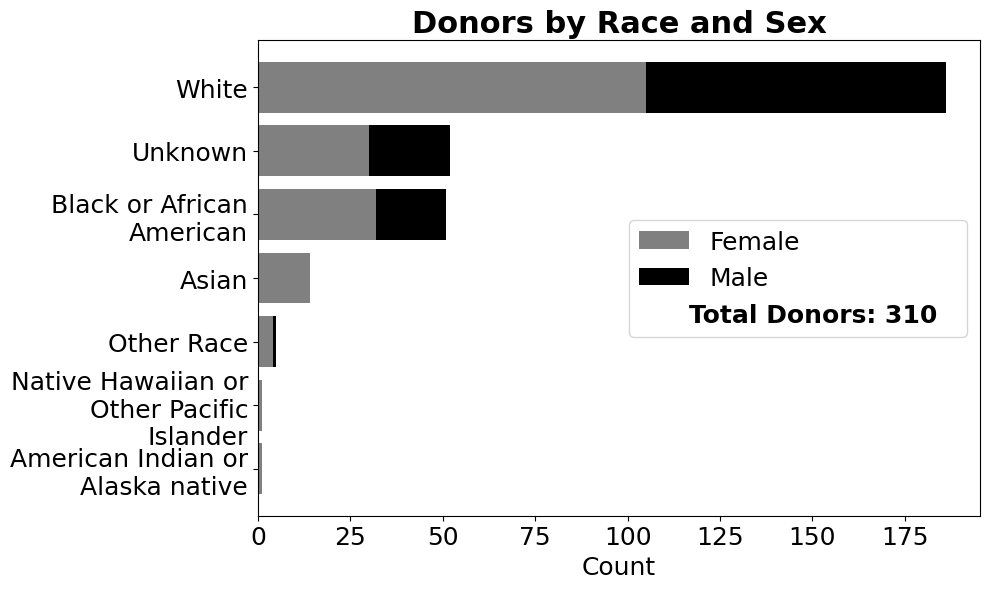

In [6]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"entity_type.keyword": "Donor"}},
                        {"exists": {"field": "mapped_metadata.race"}},
                        {"exists": {"field": "mapped_metadata.sex"}}
                    ]
                }
            },
            "aggs": {
                "by_sex": {
                    "terms": {
                        "field": "mapped_metadata.sex.keyword",
                        "size": 2
                    },
                    "aggs": {
                        "race_breakdown": {
                            "terms": {
                                "field": "mapped_metadata.race.keyword",
                                "size": 10
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['by_sex']['buckets']

races = sorted({b['key'] for g in hits for b in g['race_breakdown']['buckets']})

# Initialize count dicts
male_counts = {r: 0 for r in races}
female_counts = {r: 0 for r in races}

# Fill counts per race per sex
for g in hits:
    sex = g.get('key', '')
    for b in g['race_breakdown']['buckets']:
        race = b['key']
        count = b['doc_count']
        if sex == "Male":
            male_counts[race] = count
        elif sex == "Female":
            female_counts[race] = count
        # ignore other labels if present

# Compute totals for sorting
totals = {race: male_counts[race] + female_counts[race] for race in races}
races_sorted = sorted(races, key=lambda r: totals[r])

male_vals_sorted   = [male_counts[r] for r in races_sorted]
female_vals_sorted = [female_counts[r] for r in races_sorted]
grand_total = sum(totals.values())

fig, ax = plt.subplots(figsize=(10, 6))

female_bars = ax.barh(
    races_sorted,
    female_vals_sorted,
    label="Female",
    color="gray"
)
male_bars = ax.barh(
    races_sorted,
    male_vals_sorted,
    left=female_vals_sorted,
    label="Male",
    color="black"
)

ax.set_xlabel("Count", fontsize=18)
ax.set_title("Donors by Race and Sex", fontsize=22, fontweight=600)
ax.tick_params(axis="both", which="major", labelsize=18)

# Wrap y-axis labels
wrapped_labels = ["\n".join(textwrap.wrap(label, 20)) for label in races_sorted]
ax.set_yticks(ax.get_yticks())  # preserve positions
ax.set_yticklabels(wrapped_labels)

# Dummy entry for total donors
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="right", frameon=True, fontsize=18)

for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(18)
        text.set_ha("left")
        text.set_position((-20, 0))

plt.tight_layout()
fig.savefig(outdir / "figure_1b_1.svg", format="svg")
plt.show()

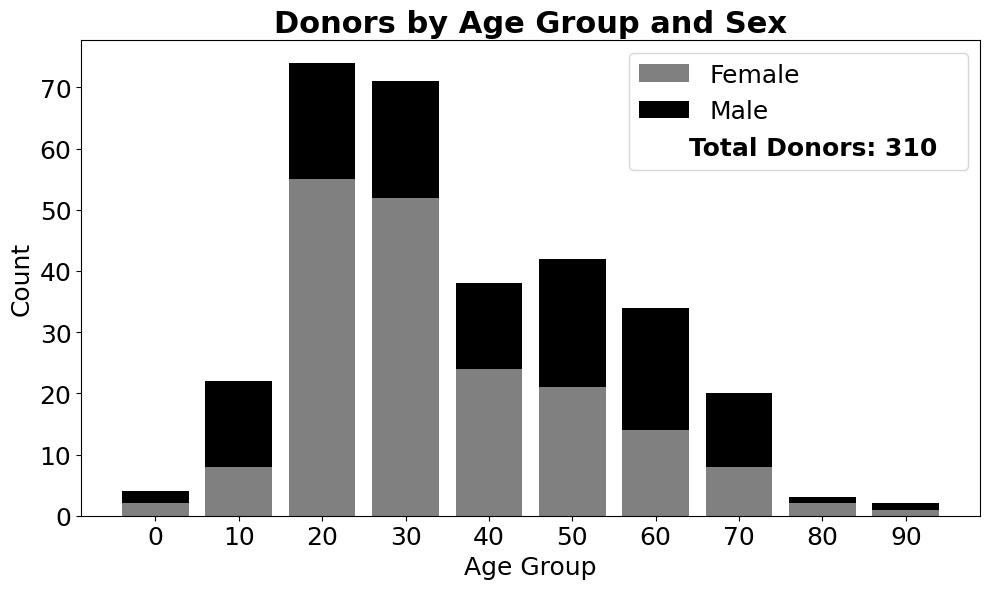

In [7]:
hits = json.loads(
    requests.post(
        search_api,
        json={
          "size": 0,
          "query": {
              "bool": {
                  "must": [
                      {"term": {"entity_type.keyword": "Donor"}},
                      {"exists": {"field": "mapped_metadata.age_value"}},
                      {"exists": {"field": "mapped_metadata.sex"}}
                  ]
              }
          },
          "aggs": {
              "by_sex": {
                  "terms": {
                      "field": "mapped_metadata.sex.keyword",
                      "size": 2
                  },
                  "aggs": {
                      "age_distribution": {
                          "histogram": {
                              "field": "mapped_metadata.age_value",
                              "interval": 10
                          }
                      }
                  }
              }
          }
      }
    ).text
)['aggregations']['by_sex']['buckets']


# Extract (age_bin -> count) mappings for each sex
female_age_counts = {b["key"]: b["doc_count"] for b in hits[0]["age_distribution"]["buckets"]}
male_age_counts   = {b["key"]: b["doc_count"] for b in hits[1]["age_distribution"]["buckets"]}

# Union of all age bins (ensure alignment even if one sex is missing a bin)
all_ages = sorted(set(female_age_counts.keys()) | set(male_age_counts.keys()))

# Build aligned series
female_vals = [female_age_counts.get(age, 0) for age in all_ages]
male_vals   = [male_age_counts.get(age, 0) for age in all_ages]

# Grand total donors
grand_total = sum(female_vals) + sum(male_vals)

# Choose a bar width appropriate for your binning
bar_width = 8

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
female_bars = ax.bar(
    all_ages,
    female_vals,
    width=bar_width,
    label="Female",
    color="gray"
)
male_bars = ax.bar(
    all_ages,
    male_vals,
    width=bar_width,
    bottom=female_vals,
    label="Male",
    color="black"
)

ax.set_title("Donors by Age Group and Sex", fontsize=22, fontweight=600)
ax.set_xlabel("Age Group", fontsize=18)   # was 12 → now 18
ax.set_ylabel("Count", fontsize=18)       # was 12 → now 18
ax.set_xticks(all_ages)

# Make tick labels bigger
ax.tick_params(axis="both", which="major", labelsize=18)

# Add a bold, left-aligned "Total Donors" entry to the legend
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels  = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="best", frameon=True, fontsize=18)

# Style the total entry
for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(18)   # 👈 ensure same size
        text.set_ha("left")
        text.set_position((-20, 0))

plt.tight_layout()
fig.savefig(outdir / "figure_1b_2.svg", format="svg")
plt.show()


# Figure 1c

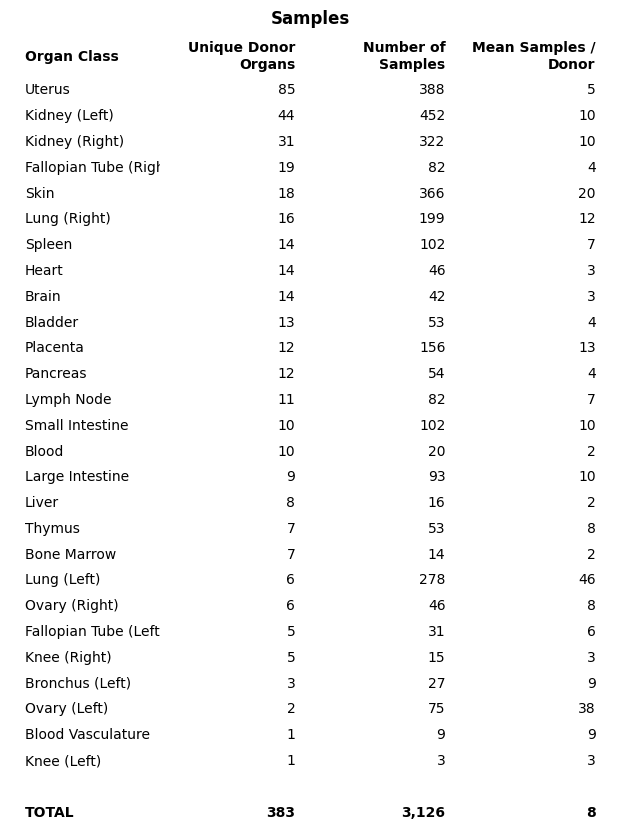

In [8]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "term": {
                                        "entity_type.keyword": "Sample"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",  # Group by organ
                        "size": 100
                    },
                    "aggs": {
                        "unique_donors": {
                            "cardinality": {
                                "field": "donor.uuid.keyword"  # Count unique donors
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_organ']['buckets']

# Build rows from ES buckets
rows = []
for b in hits:
    organ = b["key"]
    samples = int(b["doc_count"])
    donors = int(b["unique_donors"]["value"])
    mean = (samples / donors) if donors else 0.0
    rows.append((organ, donors, samples, mean))

# Sort by unique donors (desc)
rows.sort(key=lambda r: r[1], reverse=True)

# Totals row
total_donors = sum(r[1] for r in rows)
total_samples = sum(r[2] for r in rows)
total_mean = (total_samples / total_donors) if total_donors else 0.0

# Prepare columns + table data (include a spacer row, then TOTAL)
columns = ["Organ Class", "Unique Donor Organs", "Number of Samples", "Mean Samples / Donor"]
table_data = [
    [org, f"{donors:,}", f"{samples:,}", f"{round(mean)}"]
    for (org, donors, samples, mean) in rows
]
table_data.append(["", "", "", ""])  # spacer
table_data.append(["TOTAL", f"{total_donors:,}", f"{total_samples:,}", f"{round(total_mean)}"])

# Wrap headers
wrapped_columns = ["\n".join(textwrap.wrap(col, 15)) + "\n" for col in columns]

fig, ax = plt.subplots(figsize=(10, len(table_data) * 0.45))
ax.axis("off")

ax.set_title("Samples", fontsize=12, weight="600", pad=20, loc="center")

table = ax.table(
    cellText=table_data,
    colLabels=wrapped_columns,
    cellLoc="center",
    bbox=[0, 0, 1, 1]
)

# Style tweaks
table.auto_set_font_size(False)
table.set_fontsize(10)

last_row = len(table_data)
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")
    if row == last_row:
        cell.set_text_props(weight="bold")
    if col == 0:
        cell._text.set_ha("left")
    else:
        cell._text.set_ha("right")

for _, cell in table.get_celld().items():
    cell.set_edgecolor("none")

fig.canvas.draw()
bbox = table.get_window_extent(fig.canvas.get_renderer())
width = bbox.width / fig.dpi
height = bbox.height / fig.dpi
fig.set_size_inches(width, height)

plt.savefig(outdir / "figure_1c.svg", format="svg", bbox_inches="tight", pad_inches=0)
plt.show()

# Figure 1d

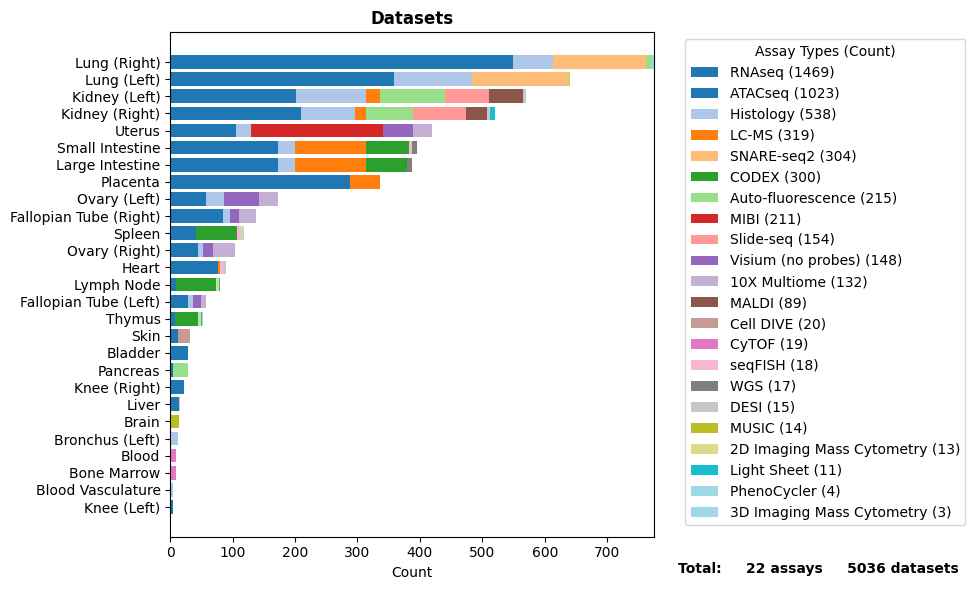

In [9]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "assay_types": {
                            "terms": {
                                "field": "raw_dataset_type.keyword",
                                "size": 50  # Adjust if necessary
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']


# Sort data by total doc_count in descending order
data_sorted = sorted(hits, key=lambda x: x['doc_count'], reverse=True)

# Extract organs and their total counts
organs = [item['key'] for item in data_sorted]
total_counts = [item['doc_count'] for item in data_sorted]

# Extract unique assay types
assay_types = {assay['key'] for item in data_sorted for assay in item['assay_types']['buckets']}

# Initialize a dictionary to hold counts for each assay type per organ
assay_counts = {assay: [] for assay in assay_types}
total_assay_counts = {assay: 0 for assay in assay_types}  # Store total counts for legend

# Populate the assay_counts dictionary
for item in data_sorted:
    assay_dict = {assay['key']: assay['doc_count'] for assay in item['assay_types']['buckets']}
    for assay in assay_types:
        count = assay_dict.get(assay, 0)
        assay_counts[assay].append(count)
        total_assay_counts[assay] += count  # Accumulate total assay counts

# Sort assay types by total count in descending order
sorted_assays = sorted(total_assay_counts.keys(), key=lambda x: total_assay_counts[x], reverse=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the bottom position for the bars
bottom = np.zeros(len(organs))

# Define color map for assay types
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_assays)))

# Build a color mapping for reuse, ensuring tuples not NumPy arrays
assay_color = {assay: tuple(color) for assay, color in zip(sorted_assays, colors)}

# Create stacked horizontal bars
for assay, color in zip(sorted_assays, colors):
    ax.barh(organs, assay_counts[assay], left=bottom, label=f"{assay} ({total_assay_counts[assay]})", color=color)
    bottom += assay_counts[assay]

# Add labels and title
ax.set_xlabel('Count')
ax.set_title('Datasets', fontweight=600)

# Calculate totals
total_assays = len(sorted_assays)          # number of distinct assays
total_datasets = sum(total_counts)         # total datasets across all organs

# Update legend to be sorted by total count (highest first)
legend = ax.legend(
    title='Assay Types (Count)',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Add totals line just beneath legend
ax.text(
    1.05, -0.05,  # position relative to axes (x > 1 puts it to the right of plot, negative y below legend)
    f"Total:     {total_assays} assays     {total_datasets} datasets",
    transform=ax.transAxes,
    ha='left', va='top', fontsize=10, fontweight='bold'
)

# Invert y-axis to have the organ with the highest count at the top
ax.invert_yaxis()

# Display the plot
plt.tight_layout()
fig.savefig(outdir / "figure_1d.svg", format="svg")
plt.show()


# Figure 1e

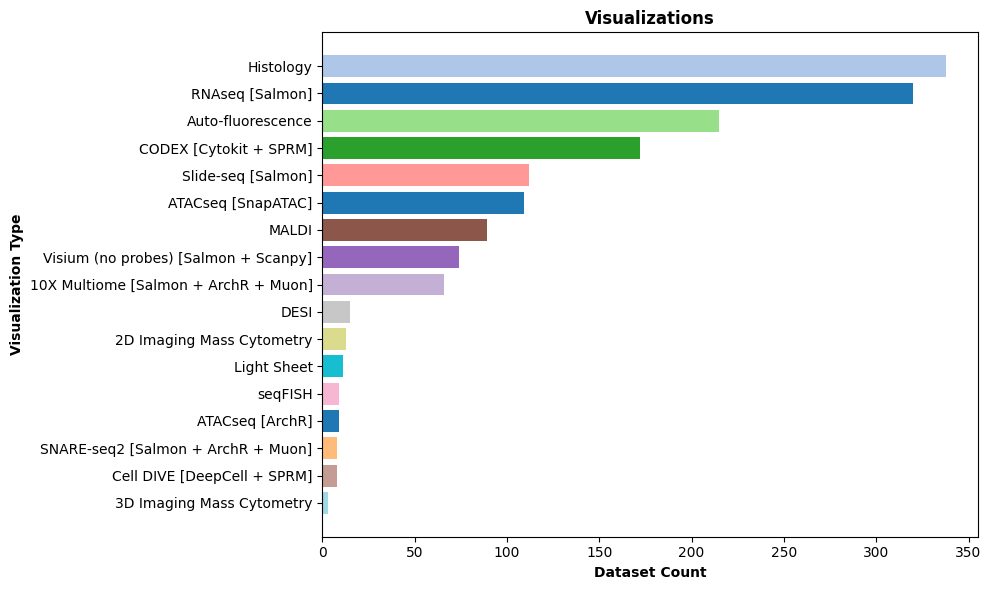

In [10]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a dataset
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                },
                                {"term": {"visualization": "true"}},
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "datasets_by_display_subtype": {
                            "terms": {
                                "field": "display_subtype.keyword",
                                "size": 100  # Adjust size based on number of unique subtypes
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']

# Aggregate dataset counts by display subtype
subtype_counts = {}
for entry in hits:
    for subtype in entry["datasets_by_display_subtype"]["buckets"]:
        subtype_counts[subtype["key"]] = subtype_counts.get(subtype["key"], 0) + subtype["doc_count"]

# Sort display subtypes by total count (descending)
subtype_counts = dict(sorted(subtype_counts.items(), key=lambda x: x[1], reverse=True))

# Extract data for plotting
subtypes = list(subtype_counts.keys())
counts = list(subtype_counts.values())

# Colors: match visualization type to assay color if assay string is contained
fallback = "lightgray"
bar_colors = []
for subtype in subtypes:
    matched_color = None
    for assay, color in assay_color.items():
        if assay.lower() in subtype.lower():  # case-insensitive substring match
            matched_color = color
            break
    bar_colors.append(matched_color if matched_color else fallback)

# Create horizontal bar chart
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.barh(subtypes, counts, color=bar_colors)

# Formatting
ax2.set_xlabel("Dataset Count", fontweight="bold")
ax2.set_ylabel("Visualization Type", fontweight="bold")
ax2.set_title("Visualizations", fontweight=600)
ax2.invert_yaxis()  # Highest count at the top

fig2.tight_layout()
fig2.savefig(outdir / "figure_1e.svg", format="svg")
plt.show()
